Косарев Егор 3821Б1ФИ2

Задача заключается в классификации результатов матчей Премьер-лиги на основе различных характеристик, таких как количество забитых и пропущенных голов, владение мячом, ожидаемые голы и другие статистические данные. Цель — предсказать результат матча (например, победа, поражение или ничья) для домашней команды.


In [44]:
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [9]:
path = kagglehub.dataset_download("mhmdkardosha/premier-league-matches")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/mhmdkardosha/premier-league-matches/versions/1


In [10]:
# 1
file_path = '/root/.cache/kagglehub/datasets/mhmdkardosha/premier-league-matches/versions/1/matches.csv'
data = pd.read_csv(file_path)
print(data.shape)

(4788, 28)


In [11]:
# 2
print(data.describe())

        Unnamed: 0           gf           ga           xg          xga  \
count  4788.000000  4788.000000  4788.000000  4788.000000  4788.000000   
mean     63.044069     1.447995     1.405388     1.396512     1.364745   
std      42.865191     1.312635     1.286927     0.828847     0.814947   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      28.000000     0.000000     0.000000     0.800000     0.700000   
50%      62.000000     1.000000     1.000000     1.300000     1.200000   
75%      87.000000     2.000000     2.000000     1.900000     1.800000   
max     182.000000     9.000000     9.000000     7.000000     7.000000   

              poss    attendance  notes           sh          sot  \
count  4788.000000   3155.000000    0.0  4788.000000  4788.000000   
mean     50.432957  38397.586688    NaN    12.619256     4.261278   
std      12.810958  17595.849137    NaN     5.548444     2.459963   
min      18.000000   2000.000000    NaN     0.000000     

gf : Среднее значение близко к нулю. Стандартное отклонение равно 1, что говорит о нормальном разбросе значений вокруг среднего. Минимальное значение -1.10 и максимальное значение 5.75 показывают, что команды могут забивать как отрицательные значения (что не имеет смысла в контексте футбольной статистики), так и до 5.75 голов в среднем.

ga : : Аналогично столбцу gf, среднее значение близко к нулю и стандартное отклонение равно 1, что указывает на стандартизацию данных.

opponent : Этот столбец, представляет собой идентификатор или код соперника. Среднее значение составляет 12, что указывает на то, что команды встречаются с соперниками разного уровня (от 0 до 25). Стандартное отклонение показывает умеренный разброс.

attendance : Средняя посещаемость составляет около 38,398 зрителей с большим разбросом (от минимумов в 2000 до максимумов в более чем 75,000). Это может указывать на разницу в посещаемости в зависимости от значимости матча или популярности команд.



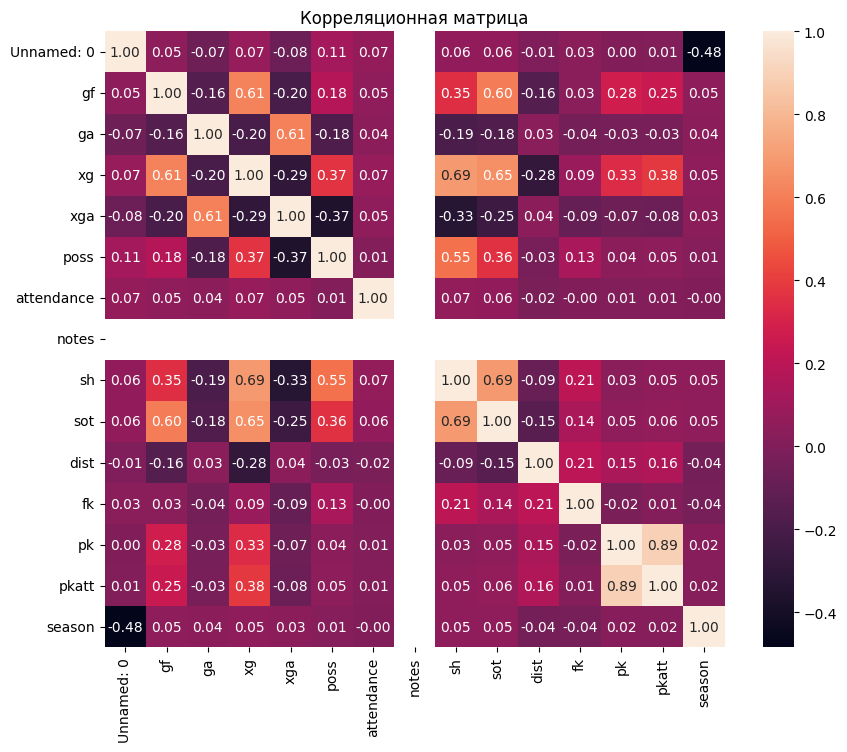

In [12]:
# 2
# Корреляционная матрица с параметром numeric_only=True
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True, fmt=".2f")
plt.title('Корреляционная матрица')
plt.show()



 Корреляционная матрица показывает взаимосвязи между числовыми признаками, такими как голы, ожидаемые голы, владение мячом, удары и другие статистические данные матчей Премьер-лиги.
 Значения корреляции варьируются от -1 до 1.

Наиболее сильные положительные корреляции наблюдаются между gf и xg (0.61), ga и xga (0.61), а также между sh и sot (0.69), что указывает на логичные связи между этими признаками.

Слабая корреляция с большинством признаков наблюдается у season и attendance, что может означать, что эти признаки мало влияют на результаты матчей.

Отрицательная корреляция между gf и ga (-0.16) и между poss и xga (-0.37) может указывать на то, что успешная игра домашней команды снижает результативность гостевой команды.

poss (владение мячом) сильно коррелирует с sh (удары) — 0.55, что логично, так как чем больше владение мячом, тем больше ударов.

xg (ожидаемые голы домашней команды) сильно коррелирует с sh (удары) — 0.69 и sot (удары в створ) — 0.65, что подтверждает, что ожидаемые голы зависят от количества ударов и ударов в створ.

season слабо коррелирует с большинством признаков, что может означать, что сезон не сильно влияет на результаты матчей.

attendance также слабо коррелирует с большинством признаков, что может указывать на то, что вместимость стадиона не сильно влияет на результаты матчей.

Признаки fk и dist также слабо коррелируют с другими признаками, что может означать, что они мало влияют на результаты матчей.

In [14]:
# 3
print(data.isnull().sum())

# Заполнение пропусков
data.loc[:, 'attendance'] = data['attendance'].fillna(data['attendance'].mean())
data.loc[:, 'dist'] = data['dist'].fillna(data['dist'].mean())
data.drop(columns=['notes'], inplace=True)

print(data.isnull().sum())

Unnamed: 0         0
date               0
time               0
comp               0
round              0
day                0
venue              0
result             0
gf                 0
ga                 0
opponent           0
xg                 0
xga                0
poss               0
attendance      1633
captain            0
formation          0
referee            0
match report       0
notes           4788
sh                 0
sot                0
dist               2
fk                 0
pk                 0
pkatt              0
season             0
team               0
dtype: int64
Unnamed: 0      0
date            0
time            0
comp            0
round           0
day             0
venue           0
result          0
gf              0
ga              0
opponent        0
xg              0
xga             0
poss            0
attendance      0
captain         0
formation       0
referee         0
match report    0
sh              0
sot             0
dist            0
fk 

Обработка пропусков в данных является важным шагом перед дальнейшим анализом. Заполнение средними значениями для числовых данных позволило сохранить информацию и избежать потерь данных. Удаление пустого столбца улучшило структуру DataFrame, сделав его более управляемым для последующего анализа.

In [15]:
#  4
# Преобразвование категориальных признаков в числовые
label_encoder = LabelEncoder()
data['team'] = label_encoder.fit_transform(data['team'])
data['opponent'] = label_encoder.fit_transform(data['opponent'])

Преобразоваю категориальные признаки team и opponent в числовые значения с помощью LabelEncoder, тем самым подготовливая данные для модели машинного обучения. Это необходимо, так как большинство моделей работают только с числовыми данными. Преобразование позволяет сохранить уникальность категорий и упростить обработку данных.

In [16]:
# 5
# Нормализация
scaler = StandardScaler()
data[['gf', 'ga', 'xg', 'poss']] = scaler.fit_transform(data[['gf', 'ga', 'xg', 'poss']])

Создаю объект scaler класса StandardScaler для нормализации данных, чтобы привести их к единому масштабу. Нормализация улучшает работу моделей, чувствительных к масштабу данных, и помогает ускорить обучение.

In [17]:
# 6
# Разбиение данных на тестовую и обучающую выборки
X = data[['gf', 'ga', 'xg', 'poss']]
y = data['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Алгоритм K-Nearest Neighbors (KNN) с параметром n_neighbors=5 для классификации. Этот алгоритм хорошо подходит для моего датасета, который содержит четко размеченные данные, позволяя эффективно классифицировать новые точки на основе ближайших соседей. Размер моего датасета составляет 4788 записей, что делает KNN подходящим выбором без значительных вычислительных затрат. Алгоритм также позволяет использовать различные метрики расстояния, что дает гибкость в адаптации модели к специфике данных. Кроме того, KNN устойчив к шуму, особенно при правильном выборе значения k, что помогает избежать переобучения.

In [42]:
#  7
# Определяем сетку параметров
param_grid = {
    'n_neighbors': [ 4, 5, 6, 7, 8, 9, 10]
}

# Создаем объект GridSearchCV
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')

# Обучаем модель
grid_search.fit(X_train, y_train)

# Выводим лучшие параметры
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'n_neighbors': 5}
Best score: 0.9929503916449086


In [39]:
# Создаем модель с лучшими параметрами
knn = KNeighborsClassifier(**grid_search.best_params_)

# Обучаем модель на обучающих данных
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [43]:
# 8
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Вычисление точности и ошибки
train_accuracy = accuracy_score(y_train, y_train_pred)
train_error = 1 - train_accuracy

test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy

print("Train Accuracy:", train_accuracy)
print("Train Error:", train_error)
print("Test Accuracy:", test_accuracy)
print("Test Error:", test_error)

Train Accuracy: 0.9966057441253263
Train Error: 0.0033942558746736795
Test Accuracy: 0.9979123173277662
Test Error: 0.0020876826722338038


Высокая точность: Точность более 99% на обоих наборах данных указывает на то, что модель хорошо справляется с задачей классификации и правильно предсказывает классы для большинства примеров.
Отсутствие переобучения: Поскольку точность на тестовом наборе близка к точности на обучающем наборе, это свидетельствует о том, что модель не переобучена и способна обобщать информацию на новых данных.

Вывод: В ходе выполнения работы я успешно обработал пропущенные значения в данных, заполнив их средними значениями и удалив ненужный столбец. Я применил LabelEncoder для кодирования категориальных признаков, что позволило подготовить данные к обучению модели. Затем я выбрал алгоритм K-Nearest Neighbors (KNN) для классификации, который показал высокую точность: 99.66% на обучающем наборе и 99.79% на тестовом. Эти результаты свидетельствуют о том, что модель эффективно справляется с задачей классификации и не переобучена.

